<a href="https://colab.research.google.com/github/robinorex/Data-Exploration-Analysis/blob/main/Diabetes_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e0bef1ad3d9c36d2b308ae33bb109e67cb0b26e80b2b8cd0193ffe9f0a486880
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName("diabetes").getOrCreate()

In [7]:
df = spark.read.csv("diabetes.csv", header=True, inferSchema=True)

In [8]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 2 rows



In [9]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [10]:
df.describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


In [11]:
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

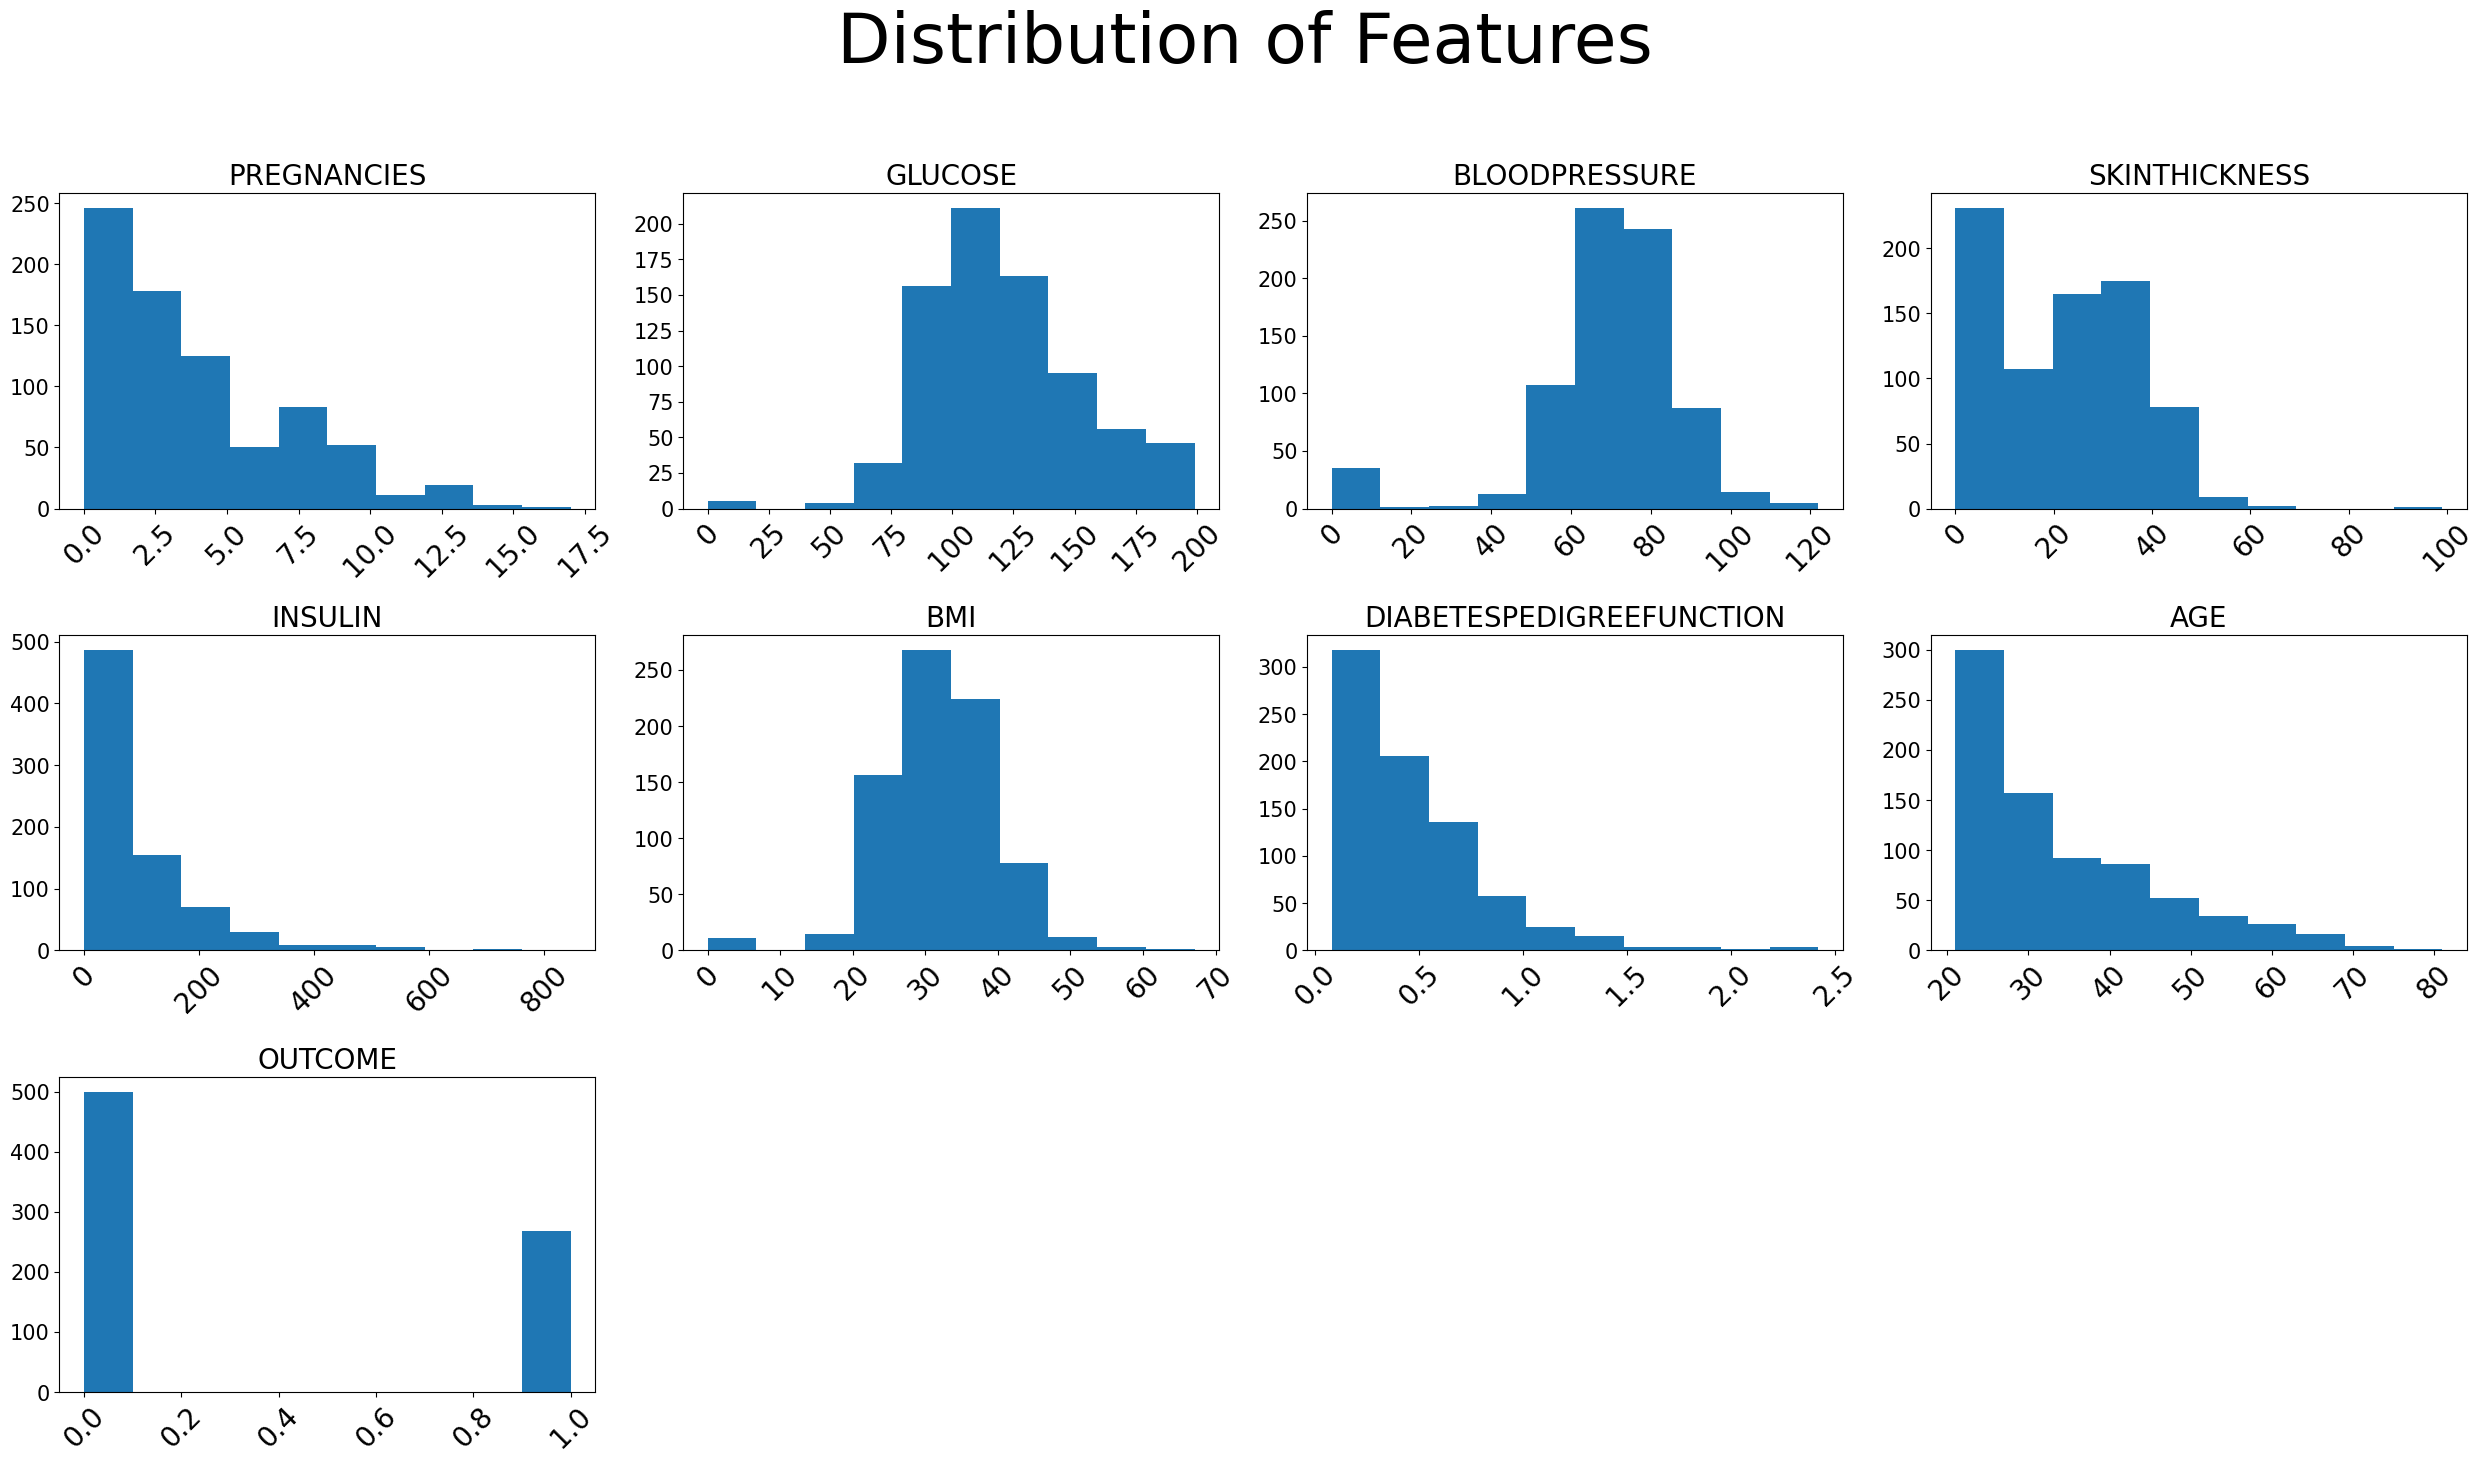

In [13]:

fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [14]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


In [15]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
#User Defined Functions
y_udf = udf(lambda y: "no" if y == 0 else "yes", StringType())

df = df.withColumn("HasDiabetes",y_udf('Outcome')).drop("Outcome")   #change outcome column to HasDiabets

df.show(3)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
only showing top 3 rows



In [16]:
def udf_multi(age):
  if (age < 25):
    return "Under 25"
  elif (age >=25 and age <= 35):
    return "Between 25 and 35"
  elif (age > 35 and age < 50):
    return "Between 36 and 50"
  elif (age >= 50):
    return "Over 50"
  else: return "NA"

In [17]:
age_udf = udf(udf_multi)
df = df.withColumn('age_udf', age_udf('Age'))

df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
only showing top 2 rows



In [18]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank, sum, desc
from pyspark.sql import Window

In [19]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [20]:
age_group_tab = df.select(["age_udf","Glucose"]).\
                      groupBy('age_udf').\
                          agg(
                              F.count('Glucose').alias('UserCount'),
                              F.mean('Glucose').alias('Glucose_AVG'),
                              F.min('Glucose').alias('Glucose_MIN'),
                              F.max('Glucose').alias('Glucose_MAX')).\
                          withColumn('total', sum(col('UserCount')).over(window)).\
                          withColumn('Percent', col('UserCount')*100 / col('total')).\
                          drop(col('total')).sort(desc('Percent'))

In [21]:
age_group_tab.toPandas()

,age_udf,UserCount,Glucose_AVG,Glucose_MIN,Glucose_MAX,Percent
0,Between 25 and 35,279,119.677419,68,198,36.328125
1,Under 25,219,110.858447,0,199,28.515625
2,Between 36 and 50,181,125.740331,0,197,23.567708
3,Over 50,89,139.550562,57,197,11.588542


from matplotlib import pyplot as plt
_df_0['UserCount'].plot(kind='hist', bins=20, title='UserCount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Glucose_AVG'].plot(kind='hist', bins=20, title='Glucose_AVG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Glucose_MIN'].plot(kind='hist', bins=20, title='Glucose_MIN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Glucose_MAX'].plot(kind='hist', bins=20, title='Glucose_MAX')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('age_udf').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='UserCount', y='Glucose_AVG', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Glucose_AVG', y='Glucose_MIN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Glucose_MIN', y='Glucose_MAX', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Glucose_MAX', y='Percent', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['UserCount'].plot(kind='line', figsize=(8, 4), title='UserCount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Glucose_AVG'].plot(kind='line', figsize=(8, 4), title='Glucose_AVG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Glucose_MIN'].plot(kind='line', figsize=(8, 4), title='Glucose_MIN')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Glucose_MAX'].plot(kind='line', figsize=(8, 4), title='Glucose_MAX')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['age_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='UserCount', y='age_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['age_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Glucose_AVG', y='age_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['age_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Glucose_MIN', y='age_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['age_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='Glucose_MAX', y='age_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_17['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['UserCount'].plot(kind='hist', bins=20, title='UserCount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['Glucose_AVG'].plot(kind='hist', bins=20, title='Glucose_AVG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20['Glucose_MIN'].plot(kind='hist', bins=20, title='Glucose_MIN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_21.groupby('age_udf').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='index', y='UserCount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='UserCount', y='Glucose_AVG', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='Glucose_AVG', y='Glucose_MIN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='Glucose_MIN', y='Glucose_MAX', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['UserCount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('age_udf')):
  _plot_series(series, series_name, i)
  fig.legend(title='age_udf', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('UserCount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Glucose_AVG']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('age_udf')):
  _plot_series(series, series_name, i)
  fig.legend(title='age_udf', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Glucose_AVG')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Glucose_MIN']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('age_udf')):
  _plot_series(series, series_name, i)
  fig.legend(title='age_udf', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Glucose_MIN')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Glucose_MAX']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_29.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('age_udf')):
  _plot_series(series, series_name, i)
  fig.legend(title='age_udf', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Glucose_MAX')

from matplotlib import pyplot as plt
_df_30['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['UserCount'].plot(kind='line', figsize=(8, 4), title='UserCount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_32['Glucose_AVG'].plot(kind='line', figsize=(8, 4), title='Glucose_AVG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_33['Glucose_MIN'].plot(kind='line', figsize=(8, 4), title='Glucose_MIN')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_34['age_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_34, x='index', y='age_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_35['age_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_35, x='UserCount', y='age_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_36['age_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_36, x='Glucose_AVG', y='age_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_37['age_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_37, x='Glucose_MIN', y='age_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [23]:
def udf_multiB(BMI):
  if (BMI < 16):
    return "Under Weight"
  elif (BMI >=16 and BMI <= 23):
    return "Normal"
  elif (BMI > 23 and BMI < 26):
    return "Heavy"
  elif (BMI >= 26):
    return "Over Weight"
  else: return "NA"

In [24]:
BMI_udf = udf(udf_multiB)
df = df.withColumn('BMI_udf', BMI_udf('BMI'))

df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|    BMI_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|Over Weight|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|Over Weight|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+-----------+
only showing top 2 rows



In [25]:
BMI_group_tab = df.select(["BMI_udf","BloodPressure"]).\
                      groupBy('BMI_udf').\
                          agg(
                              F.count('BloodPressure').alias('UserCount'),
                              F.mean('BloodPressure').alias('BloodPressure_AVG'),
                              F.min('BloodPressure').alias('BloodPressure_MIN'),
                              F.max('BloodPressure').alias('BloodPressure_MAX')).\
                          withColumn('total', sum(col('UserCount')).over(window)).\
                          withColumn('Percent', col('UserCount')*100 / col('total')).\
                          drop(col('total')).sort(desc('Percent'))

In [26]:
BMI_group_tab.toPandas()

,BMI_udf,UserCount,BloodPressure_AVG,BloodPressure_MIN,BloodPressure_MAX,Percent
0,Over Weight,613,70.921697,0,114,79.817708
1,Heavy,92,64.076087,0,98,11.979167
2,Normal,52,65.115385,0,122,6.770833
3,Under Weight,11,28.818182,0,96,1.432292


from matplotlib import pyplot as plt
_df_38['UserCount'].plot(kind='hist', bins=20, title='UserCount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_39['BloodPressure_AVG'].plot(kind='hist', bins=20, title='BloodPressure_AVG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_40['BloodPressure_MAX'].plot(kind='hist', bins=20, title='BloodPressure_MAX')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_41['Percent'].plot(kind='hist', bins=20, title='Percent')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_42.groupby('BMI_udf').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_43.plot(kind='scatter', x='UserCount', y='BloodPressure_AVG', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_44.plot(kind='scatter', x='BloodPressure_AVG', y='BloodPressure_MAX', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_45.plot(kind='scatter', x='BloodPressure_MAX', y='Percent', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['BloodPressure_MIN']
  ys = series['UserCount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_46.sort_values('BloodPressure_MIN', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('BMI_udf')):
  _plot_series(series, series_name, i)
  fig.legend(title='BMI_udf', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('BloodPressure_MIN')
_ = plt.ylabel('UserCount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['BloodPressure_MIN']
  ys = series['BloodPressure_AVG']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_47.sort_values('BloodPressure_MIN', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('BMI_udf')):
  _plot_series(series, series_name, i)
  fig.legend(title='BMI_udf', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('BloodPressure_MIN')
_ = plt.ylabel('BloodPressure_AVG')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['BloodPressure_MIN']
  ys = series['BloodPressure_MAX']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_48.sort_values('BloodPressure_MIN', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('BMI_udf')):
  _plot_series(series, series_name, i)
  fig.legend(title='BMI_udf', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('BloodPressure_MIN')
_ = plt.ylabel('BloodPressure_MAX')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['BloodPressure_MIN']
  ys = series['Percent']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_49.sort_values('BloodPressure_MIN', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('BMI_udf')):
  _plot_series(series, series_name, i)
  fig.legend(title='BMI_udf', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('BloodPressure_MIN')
_ = plt.ylabel('Percent')

from matplotlib import pyplot as plt
_df_50['UserCount'].plot(kind='line', figsize=(8, 4), title='UserCount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_51['BloodPressure_AVG'].plot(kind='line', figsize=(8, 4), title='BloodPressure_AVG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_52['BloodPressure_MAX'].plot(kind='line', figsize=(8, 4), title='BloodPressure_MAX')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_53['Percent'].plot(kind='line', figsize=(8, 4), title='Percent')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_54['BMI_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_54, x='UserCount', y='BMI_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_55['BMI_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_55, x='BloodPressure_AVG', y='BMI_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_56['BMI_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_56, x='BloodPressure_MAX', y='BMI_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_57['BMI_udf'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_57, x='Percent', y='BMI_udf', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

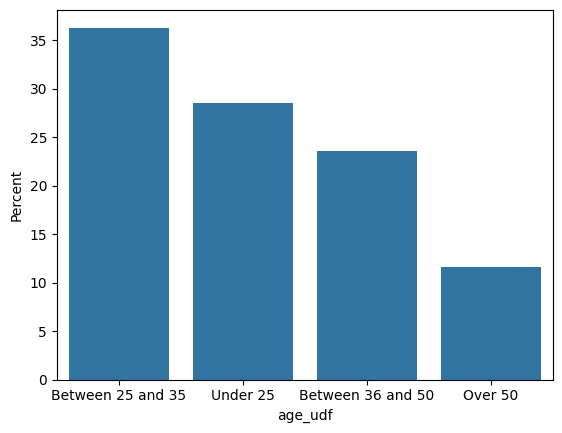

In [29]:
sns.barplot(x="age_udf", y="Percent",data=age_group_tab.toPandas());

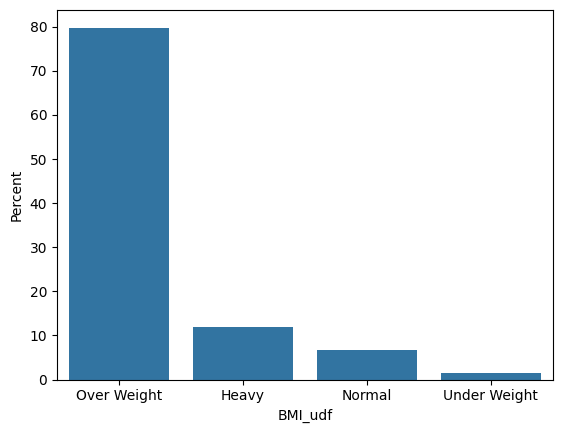

In [31]:
sns.barplot(x="BMI_udf", y="Percent",data=BMI_group_tab.toPandas());

In [32]:
numeric_features = [t[0] for t in df.dtypes if t[1] !='string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [33]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [34]:

from pyspark.mllib.stat import Statistics
import pandas as pd


In [35]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00


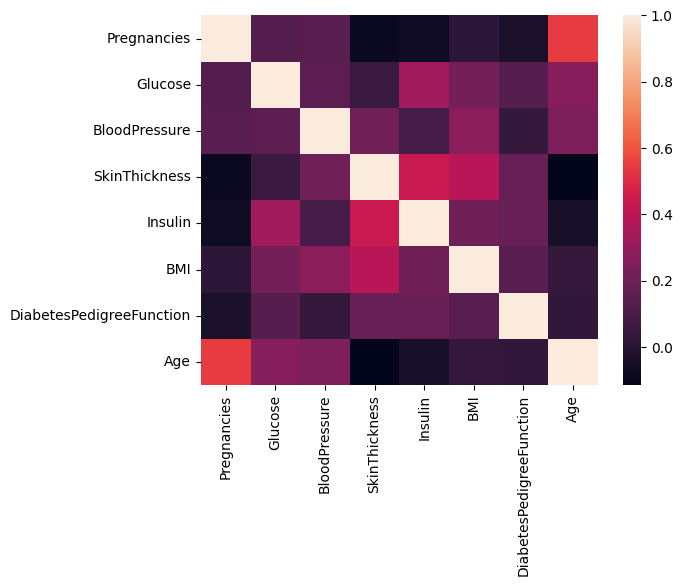

In [36]:
sns.heatmap(corr_df);